**Example: Solving differential equations numerically**

# One-dimensional example

[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


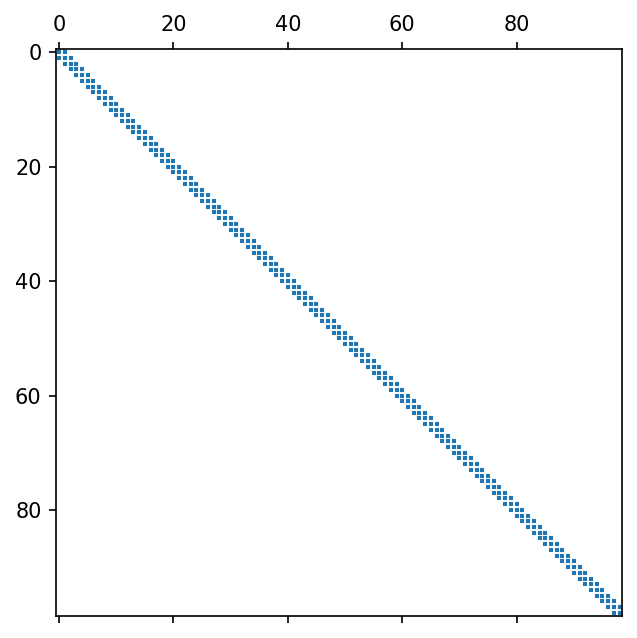

In [43]:
import numpy as np
from scipy import sparse

n = 100
e = np.ones(n)
A = sparse.spdiags([e, -2*e, e], [-1,0,1], n-1, n-1, format='csr')
print(A[:5,:5].toarray())

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5), dpi=150)
plt.spy(A, markersize=1)
plt.show()

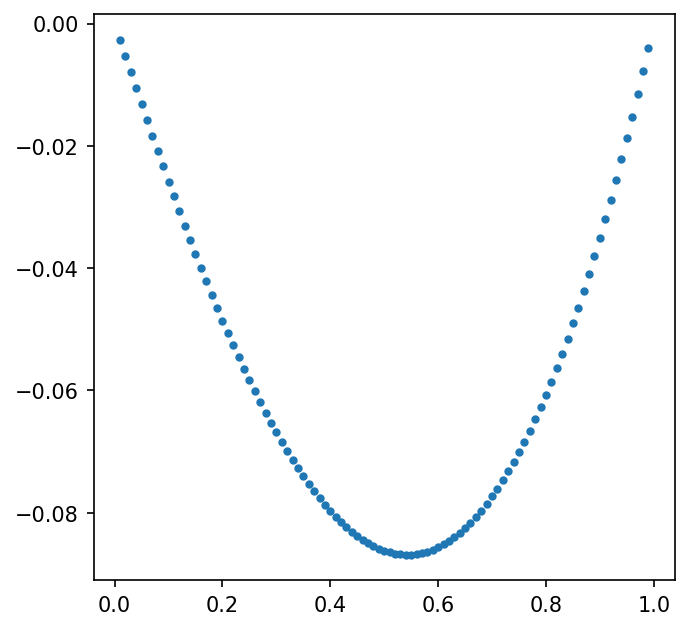

In [44]:
from scipy.sparse.linalg import bicg

b = (np.arange(1,n) ** .5) / n ** 2.5
y, exitCode = bicg(A, b)

plt.figure(figsize=(5,5), dpi=150)
plt.plot(np.arange(1,n)/n, y, '.')
plt.show()

In [ ]:
y

(array([-0.00266451, -0.00531901, -0.00795938, -0.01058242, -0.01318547,
        -0.01576615, -0.01832234, -0.02085207, -0.02335352, -0.02582497,
        -0.02826479, -0.03067145, -0.03304346, -0.03537943, -0.03767797,
        -0.03993779, -0.0421576 , -0.04433619, -0.04647234, -0.04856491,
        -0.05061276, -0.05261478, -0.0545699 , -0.05647706, -0.05833523,
        -0.06014339, -0.06190057, -0.06360579, -0.06525809, -0.06685654,
        -0.06840022, -0.06988822, -0.07131966, -0.07269364, -0.07400932,
        -0.07526584, -0.07646235, -0.07759804, -0.07867209, -0.07968368,
        -0.08063203, -0.08151635, -0.08233586, -0.0830898 , -0.0837774 ,
        -0.08439792, -0.08495062, -0.08543476, -0.08584962, -0.08619448,
        -0.08646863, -0.08667136, -0.08680199, -0.08685981, -0.08684415,
        -0.08675432, -0.08658967, -0.08634951, -0.0860332 , -0.08564007,
        -0.08516949, -0.0846208 , -0.08399337, -0.08328657, -0.08249978,
        -0.08163235, -0.08068369, -0.07965317, -0.0

# Laplace's equation on an annulus

See https://en.wikipedia.org/wiki/Laplace%27s_equation

In radial coordinates $(r, \theta)$, $$\nabla^2 f = \frac{1}{r} \frac{\partial}{\partial r} \Big(r \frac{\partial f}{\partial r}\Big) + \frac{1}{r^2} \frac{\partial^2 f}{\partial \theta^2} = \frac{\partial^2 f}{\partial r^2} + \frac{1}{r} \frac{\partial f}{\partial r} + \frac{1}{r^2} \frac{\partial^2 f}{\partial \theta^2}$$

True

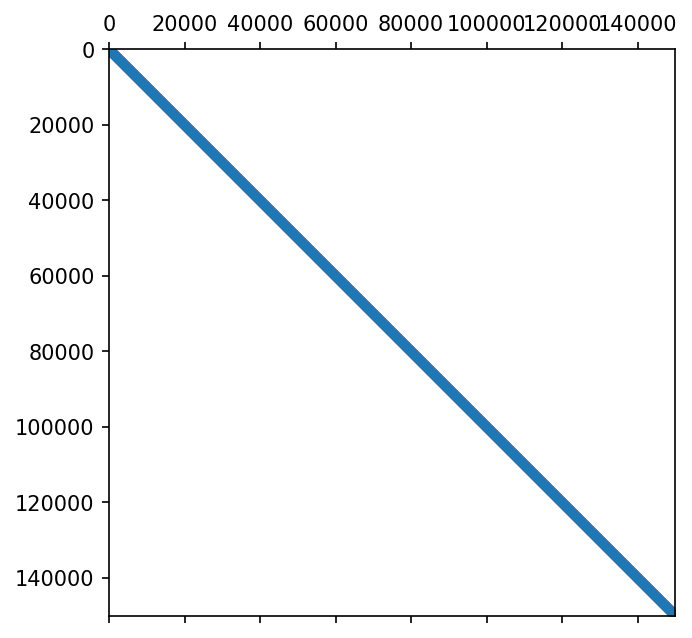

In [40]:
import numpy as np
from scipy import sparse

innerRadius = 2
outerRadius = 4

nr, ntheta = 300, 500
ntotal = nr * ntheta

radii = innerRadius + (outerRadius - innerRadius) / (nr - 1) * np.arange(nr)
OneOverR = sparse.diags(np.concatenate([np.ones(ntheta) / r for r in radii]))

D2Dtheta2 = sparse.lil_matrix((ntotal, ntotal))
for ir in range(1, nr-1):  # only for the interior points 
  for itheta in range(ntheta): 
    i = ir * ntheta + itheta
    iright = ir * ntheta + ((itheta+1)%ntheta)  # periodic boundary conditions
    ileft  = ir * ntheta + ((itheta-1)%ntheta)
    D2Dtheta2[i,i] = -2
    D2Dtheta2[i,ileft], D2Dtheta2[i,iright] = 1, 1
D2Dtheta2 = D2Dtheta2.tocsr()
D2Dtheta2 *= (ntheta / (2 * np.pi)) ** 2

DDr = sparse.lil_matrix((ntotal, ntotal))
for ir in range(1, nr-1):  # only for the interior points 
  for itheta in range(ntheta): 
    i = ir * ntheta + itheta
    iout = i + ntheta
    DDr[i,iout], DDr[i,i] = 1, -1
DDr = DDr.tocsr()
DDr *= (nr - 1) / (outerRadius - innerRadius)

D2Dr2 = sparse.lil_matrix((ntotal, ntotal))
for ir in range(1, nr-1):  # only for the interior points 
  for itheta in range(ntheta): 
    i = ir * ntheta + itheta
    iin, iout = i - ntheta, i + ntheta
    D2Dr2[i,i] = -2
    D2Dr2[i,iin], D2Dr2[i,iout] = 1, 1
D2Dr2 = D2Dr2.tocsr()
D2Dr2 *= ((nr - 1) / (outerRadius - innerRadius)) ** 2

#Iinnerboundary = sparse.eye(ntheta, n=ntotal)
#Iouterboundary = sparse.eye(ntheta, n=ntotal, k=ntotal-ntheta)
boundaries = sparse.lil_matrix((ntotal, ntotal))
for ir in (0,nr-1):  
  for itheta in range(ntheta): 
    i = ir * ntheta + itheta
    boundaries[i,i] = 1
boundaries = boundaries.tocsr()
# note that boundaries is the identity on the first and last itheta rows
# the other matrices are 0 in these rows 

A = D2Dr2 + OneOverR * DDr + OneOverR * OneOverR * D2Dtheta2 + boundaries
b = np.concatenate(
    (np.zeros(ntheta), 
     np.zeros((nr-2)*ntheta), 
     [4 * np.sin(5 * (2 * np.pi / ntheta) * i) for i in range(ntheta)])
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5), dpi=150)
plt.spy(A, markersize=1)

from scipy.sparse.linalg import spsolve, bicg, bicgstab, lsmr
#x, exitCode = bicg(A, b) # bicg isn't working well?
x = spsolve(A, b)
#x = lsmr(A, b)[0]  # iterative least-squares solver

np.allclose(A.dot(x), b)

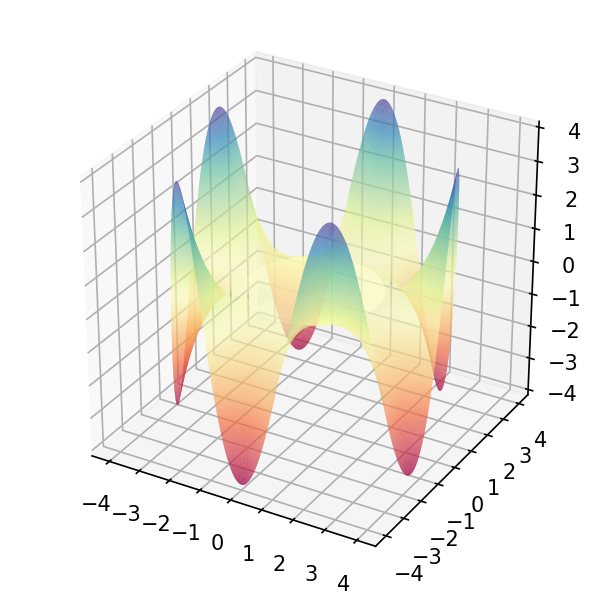

In [42]:
# now we plot the data in 3d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111, projection='3d')

radii = innerRadius + (outerRadius - innerRadius) / (nr - 1) * np.arange(nr)
xvals = np.concatenate([[r * np.cos((2 * np.pi / ntheta) * i) for i in range(ntheta)] 
                       for r in radii])
yvals = np.concatenate([[r * np.sin((2 * np.pi / ntheta) * i) for i in range(ntheta)] 
                       for r in radii])
ax.plot_trisurf(xvals, yvals, x, linewidth=0, antialiased=True, cmap=plt.cm.Spectral)
plt.show()

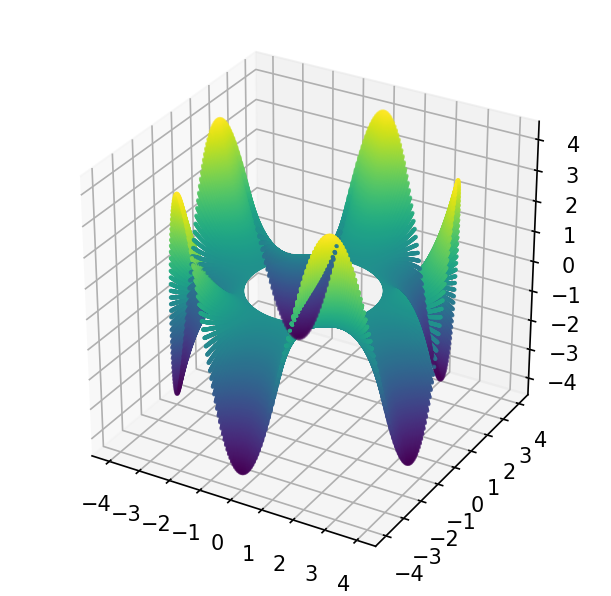

In [41]:
# now we plot the data in 3d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111, projection='3d')

radii = innerRadius + (outerRadius - innerRadius) / (nr - 1) * np.arange(nr)
xvals = np.concatenate([[r * np.cos((2 * np.pi / ntheta) * i) for i in range(ntheta)] 
                       for r in radii])
yvals = np.concatenate([[r * np.sin((2 * np.pi / ntheta) * i) for i in range(ntheta)] 
                       for r in radii])
ax.scatter(xs=xvals, ys=yvals, zs=x, c=x, s=1)
plt.show()

# More code

It would be nice to have a two-dimensional heat-map plot, but the radial coordinates make this slightly tricky

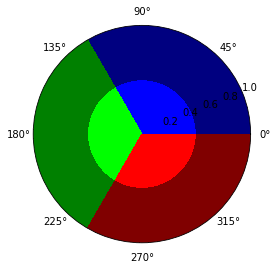

In [16]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array([[[0,0,1],[0,1,0],[1,0,0]],
                 [[0,0,0.5],[0,0.5,0],[0.5,0,0]]])
data = np.repeat(data, 25, axis=1)

ax = plt.subplot(111, polar=True)

#get coordinates:
phi = np.linspace(0,2*np.pi,data.shape[1]+1)
r = np.linspace(0,1,data.shape[0]+1)
Phi,R = np.meshgrid(phi, r)
# get color
color = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))

# plot colormesh with Phi, R as coordinates, 
# and some 2D array of the same shape as the image, except the last dimension
# provide colors as `color` argument
m = plt.pcolormesh(Phi,R,data[:,:,0], color=color, linewidth=0)
# This is necessary to let the `color` argument determine the color
m.set_array(None)

plt.show()